# Gaussian Process Regression for Ocean Temperature Anomaly Detection

In this exploratory Earth science and machine learning project, I investigate the detection of climate anomalies by modeling ocean temperature behavior. The goal is to train a regression model that captures the "normal" behavior of the **temperature drop across the ocean's cool layer** based on related meteorological variables.

To achieve this, I use **Gaussian Process Regression (GPR)**, a non-parametric Bayesian model well-suited for small, spatially structured, and noisy datasets. GPR not only provides accurate predictions, but also quantifies the uncertainty of those predictions.

The model is trained using real satellite-based reanalysis data from **August 1st, 2018**, which includes 24 hourly observations of global ocean-related variables. These variables include:

- `tbar`: mean temperature of the interface layer  
- `tskinice`: sea ice skin temperature  
- `rainocn`: ocean rainfall  
- `delts`: change of surface skin temperature

In this work, I assume that the target variable is `tdrop`, and the model learns to predict it using the 4 features above.


In this notebook, I apply the model presentetd in the separeted notebook 'train_model.ipynb' to data from **August 1st, 2021** to identify locations and times where observed `tdrop` deviates significantly from model expectations, revealing potential anomalies related to changing climate patterns.

This notebook includes the analysis of prediction results, error patterns, and anomaly visualization.

# Data and model loading
We begin by loading both the 2018 training dataset and the 2021 test dataset. If the model is not found, it will be trained using the same routine from the training notebook.


In [3]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler


In [4]:
# Load 2021 dataset
data_2021 = 'OCEAN_RELATED_DATA/2021/tavg1_2d_ocn_Nx-202109201500output.18042.webform.nc4'
ds_2021 = xr.open_dataset(data_2021)

# Load 2018 dataset
data_2018 = 'OCEAN_RELATED_DATA/2018/tavg1_2d_ocn_Nx-202109201458output.17833.webform.nc4'
ds_2018 = xr.open_dataset(data_2018)

# Variables and params
features = ['tbar', 'tskinice', 'rainocn', 'delts']
target = 'tdrop'

In [5]:
# Load or train model if missing
from train_model import train_and_save_gpr_model

if os.path.exists("gpr_model.pkl") and os.path.exists("gpr_scaler.pkl"):
    gpr = joblib.load("gpr_model.pkl")
    scaler = joblib.load("gpr_scaler.pkl")
    print("Model and scaler loaded.")
else:
    print("Model not found. Training now...")
    gpr, scaler = train_and_save_gpr_model()


Model and scaler loaded.


We use a spatial subsampling (every 10 grid points in latitude and longitude) to reduce computational cost, since GPR is expensive to evaluate.
We also use selected time steps (every 4 hours) to get a representative sample through the day.

In [6]:
time_steps = [0, 4, 8, 12, 16, 20]
lat_subsample = 10
lon_subsample = 10

# Prepare test data
X_test, y_test, coords = [], [], []
for t in time_steps:
    for lat in range(0, len(ds_2021.latitude), lat_subsample):
        for lon in range(0, len(ds_2021.longitude), lon_subsample):
            f_vals = [ds_2021[var][t, lat, lon].item() for var in features]
            if not any(np.isnan(f_vals)):
                X_test.append(f_vals)
                y_test.append(ds_2021[target][t, lat, lon].item())
                coords.append((t, lat, lon))

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test_scaled = scaler.transform(X_test)



# Predict and compute errors

In [7]:
# Predict
y_pred, y_std = gpr.predict(X_test_scaled, return_std=True)
error = y_test - y_pred
abs_error = np.abs(error)


In [8]:
print("\n📈 Prediction Error Summary:")
print(f"MAE: {np.mean(abs_error):.4f}")
print(f"Max error: {np.max(abs_error):.4f}")


📈 Prediction Error Summary:
MAE: 0.1073
Max error: 0.9404


# Normalized error using GPR uncertainty (Z-scores)
To quantify how confident we are in the anomalies, we normalize the prediction error by the model's standard deviation at each point:
$$
z = \frac{|y_{test} - y_{pred}|}{y_{std}}
$$


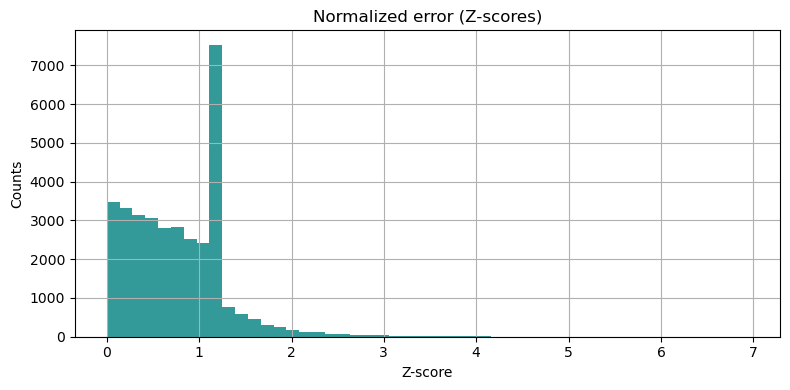

In [14]:
y_std_safe = np.where(y_std == 0, 1e-6, y_std)
z_scores = np.abs(error / y_std_safe)

plt.figure(figsize=(8, 4))
plt.hist(z_scores, bins=50, color='teal', alpha=0.8)
plt.title("Normalized error (Z-scores)")
plt.xlabel("Z-score")
plt.ylabel("Counts")
plt.grid(True)
plt.tight_layout()
plt.show()

# Top anomalies by Z-score
These are the most statistically significant deviations between model and data.



In [10]:
print("Top anomalies by Z-score:")
top_z_idx = np.argsort(-z_scores)[:10]
for i in top_z_idx:
    t, lat, lon = coords[i]
    print(f"Time {t}, Lat {ds_2021.latitude[lat].item():.2f}, Lon {ds_2021.longitude[lon].item():.2f}, "
          f"Z-score: {z_scores[i]:.2f}, Std: {y_std[i]:.3f}, Abs Error: {abs_error[i]:.3f}")


Top anomalies by Z-score:
Time 4, Lat -77.50, Lon -39.38, Z-score: 6.94, Std: 0.135, Abs Error: 0.940
Time 8, Lat -75.00, Lon -33.12, Z-score: 6.15, Std: 0.135, Abs Error: 0.833
Time 0, Lat -77.50, Lon -36.25, Z-score: 6.10, Std: 0.135, Abs Error: 0.826
Time 8, Lat -77.50, Lon -151.88, Z-score: 5.82, Std: 0.135, Abs Error: 0.789
Time 0, Lat -67.50, Lon 41.88, Z-score: 5.82, Std: 0.135, Abs Error: 0.788
Time 4, Lat -75.00, Lon -33.12, Z-score: 5.41, Std: 0.135, Abs Error: 0.732
Time 8, Lat -65.00, Lon 29.38, Z-score: 5.13, Std: 0.135, Abs Error: 0.695
Time 0, Lat -77.50, Lon -39.38, Z-score: 5.09, Std: 0.135, Abs Error: 0.689
Time 16, Lat -75.00, Lon -180.00, Z-score: 5.07, Std: 0.135, Abs Error: 0.687
Time 16, Lat -75.00, Lon 179.38, Z-score: 5.02, Std: 0.135, Abs Error: 0.680


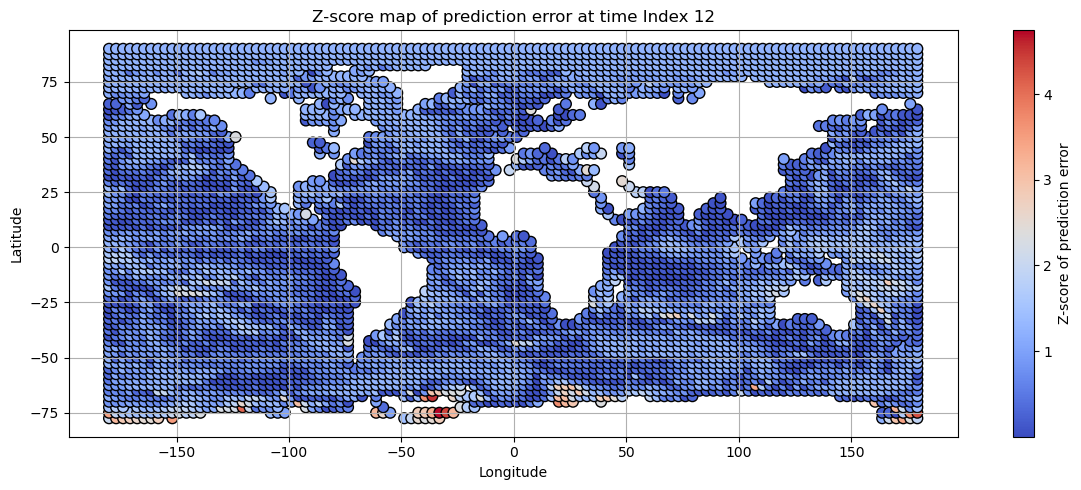

In [15]:
import pandas as pd

df = pd.DataFrame(coords, columns=["time_idx", "lat_idx", "lon_idx"])
df["y_pred"] = y_pred
df["y_std"] = y_std
df["y_true"] = y_test
df["error"] = np.abs(df["y_true"] - df["y_pred"])
df["z_score"] = df["error"] / df["y_std"]

df["lat"] = df["lat_idx"].apply(lambda i: ds_2021.latitude[i].item())
df["lon"] = df["lon_idx"].apply(lambda i: ds_2021.longitude[i].item())



selected_time = 12
df_time = df[df["time_idx"] == selected_time].copy()

plt.figure(figsize=(12, 5))
sc = plt.scatter(
    df_time["lon"], df_time["lat"],
    c=df_time["z_score"],
    cmap="coolwarm",
    s=60,
    edgecolors='k'
)
plt.colorbar(sc, label="Z-score of prediction error")
plt.title(f"Z-score map of prediction error at time Index {selected_time}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.tight_layout()
plt.show()



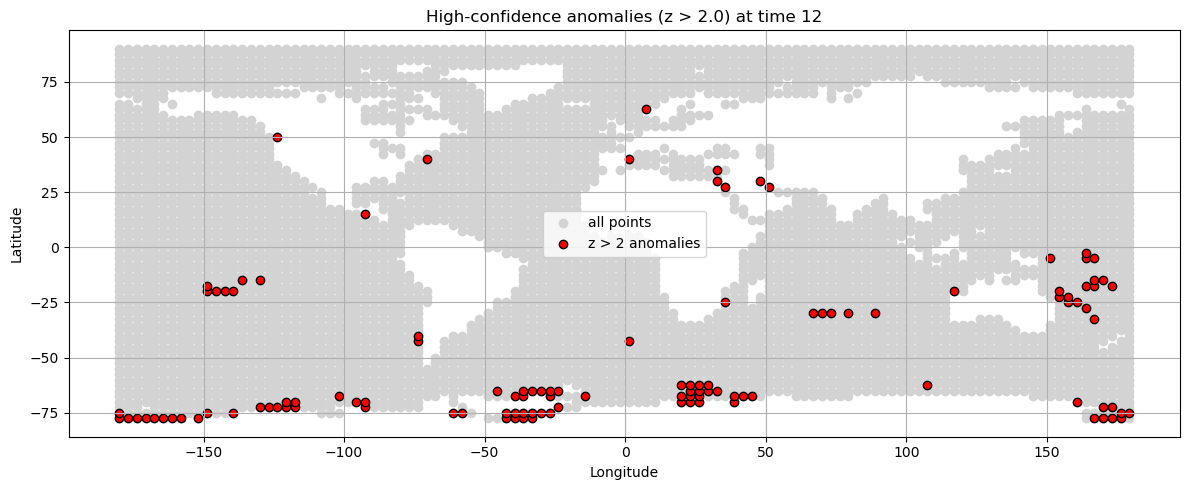

In [17]:
threshold_topan = 2.0
df_top_anom = df_time[df_time["z_score"] > threshold_topan]

plt.figure(figsize=(12, 5))
plt.scatter(df_time["lon"], df_time["lat"], c='lightgray', label='all points')
plt.scatter(df_top_anom["lon"], df_top_anom["lat"], c='red', label='z > 2 anomalies', edgecolors='k')
plt.title(f"High-confidence anomalies (z > {threshold_topan}) at time {selected_time}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Conclusion and Discussion

In this notebook, I applied a Gaussian Process Regression (GPR) model trained on ocean-related satellite data from 2018 to make predictions of the `tdrop` variable for the year 2021.

Thanks to the probabilistic nature of GPR, I was able to not only make accurate point predictions, but also quantify uncertainty in those predictions. This allowed for:
- an error analysis, including spatial anomaly detection,
- a confidence-aware Z-score anomaly map, identifying where predictions significantly diverged from observed values beyond expected noise.

Most `tdrop` predictions were accurate with a low MAE (~0.1), but some localized anomalies (z > 2) were identified, particularly in Antarctic and sub-Antarctic waters. Note that `tdrop` has mainly range from 0.1 $^o$C to 0.4 $^o$C.
These anomalies may be driven by unusual atmospheric or oceanic events, or model limitations (e.g., unseen 2021 conditions).
GPR uncertainty estimates provided a principled way to distinguish between true anomalies and noise.

To improve this work one could incorporate more features (e.g., wind, cloud cover) or longer training data across multiple years, use temporal kernels or recurrent models to better capture dynamics and perform a climatological evaluation of anomalies across several years.
